# Importing Libraries

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### Constants



In [123]:
# Data used for analysis
DATA='GBPUSD'

# The events data prices before and after the event
HOURS_BEFORE=2
HOURS_AFTER=24

# price columns 
PRICE_COLUMNS = [str(num)+'h' for num in np.arange(-HOURS_BEFORE,HOURS_AFTER+1)]

# Predition columns
PREDICTED_FUTURE_PRICES = ['1h','3h','5h']

# PRICES TO DROP WHICH WE DONT NEED
PRICES_TO_DROP = PRICE_COLUMNS.copy()
for price in PREDICTED_FUTURE_PRICES:
    PRICES_TO_DROP.remove(price)
PRICES_TO_DROP.remove('0h')

# Events information columns
EVENT_COLUMNS = ['time','currency','description','impact','actual','deviation','consensus','previous','result']

# Since we already have extracted the meaning of this columns in the result we are discarding this columns
EVENT_COLUMNS_DROP = ['actual','deviation','consensus','previous']

# IMPACT COLORS to visualize
IMPACT_COLORS = {
    'low': '#F5C861',
    'medium': '#E4871B',
    'high': '#D25746',
    'none': 'black'
}

NULL_COLUMNS = []

FEATURES_INFO = {
    'time' : 'Time of event occuring',
    'currency': 'Currencies might be affected',
    'description' : 'Event Information',
    'impact': 'The impact is a basic indicator of the potential move a data release might trigger on currencies. Shall a bar be red and long, market observers expect this data to have great probability to move the Forex market. Shall this bar be yellow and short, the probability is viewed as low. In orange, we’re just in between.(Red: High,Orange: Medium,yellow: low, White: none)',
    'actual': 'Actual Value when event occured',
    'deviation': 'It measures the surprise caused when the Actual data differs from the Consensus. It can oscillate in an open scale usually between -7 and +7.',
    'consensus': 'It is a general agreement of experts on the outcome of the number.',
    'previous': 'It is the data in its last release (frequency of data release is variable: it can be last month, last trimester…).',
    'result' : 'Green: better than expected Red: worse than expected, Black : neutral'
}
for item in PRICE_COLUMNS:
    if item.startswith('-') or item.startswith('0h'):
        FEATURES_INFO[item] = 'Price before ' + item + ' of the event'
    else:
        FEATURES_INFO[item] = 'Price after ' + item + ' of the event'

In [124]:
EVENT_COLUMNS

['time',
 'currency',
 'description',
 'impact',
 'actual',
 'deviation',
 'consensus',
 'previous',
 'result']

In [125]:
PRICE_COLUMNS

['-2h',
 '-1h',
 '0h',
 '1h',
 '2h',
 '3h',
 '4h',
 '5h',
 '6h',
 '7h',
 '8h',
 '9h',
 '10h',
 '11h',
 '12h',
 '13h',
 '14h',
 '15h',
 '16h',
 '17h',
 '18h',
 '19h',
 '20h',
 '21h',
 '22h',
 '23h',
 '24h']

# Load Data

In [126]:
# Load the data according to the currency
frame = pd.read_csv('./data/events_'+DATA+'.csv',index_col=['time'],header=0)
# frame = pd.read_csv('./data/economic_events_'+DATA+'.csv',index_col=['time'],header=0)

# Convert the time string to datetime object
frame.index = pd.to_datetime(frame.index,format='%Y-%m-%d %H:%M:%S%z',utc=True)

# hex color actual colum contains the result : positive-green, negative - red, black-neutral
frame.rename(columns={'hex_color_actual':'result'},inplace=True)
type(frame.index)
frame.attrs['features'] = FEATURES_INFO
# Create MultiIndex
# frame['time'] = pd.to_datetime(frame['time'],format='%Y-%m-%d %H:%M:%S%z',utc=True)
# frame.set_index(['time','currency','description'])


# EDA

In [127]:
# Shape of the dataset
frame.shape

(19368, 35)

In [128]:
# Info about the dataset
frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19368 entries, 2013-01-02 10:28:00+00:00 to 2024-06-28 14:00:00+00:00
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   currency     19368 non-null  object 
 1   description  19368 non-null  object 
 2   impact       19368 non-null  object 
 3   actual       19368 non-null  object 
 4   deviation    19368 non-null  object 
 5   consensus    19368 non-null  object 
 6   previous     19368 non-null  object 
 7   result       19368 non-null  object 
 8   -2h          19366 non-null  float64
 9   -1h          19364 non-null  float64
 10  0h           19359 non-null  float64
 11  1h           19326 non-null  float64
 12  2h           19267 non-null  float64
 13  3h           19241 non-null  float64
 14  4h           19231 non-null  float64
 15  5h           19213 non-null  float64
 16  6h           18858 non-null  float64
 17  7h           18570 non-null  float64
 18 

In [129]:
# Basic Stats
frame.describe()

,-2h,-1h,0h,1h,2h,3h,4h,5h,6h,7h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
count,19366.000000,19364.000000,19359.000000,19326.000000,19267.000000,19241.000000,19231.000000,19213.000000,18858.000000,18570.000000,...,15136.000000,15129.000000,15129.000000,15129.00000,15129.000000,15122.000000,15063.000000,15051.000000,15037.000000,15026.000000
mean,1.365644,1.365600,1.365597,1.365575,1.365524,1.365380,1.365304,1.365272,1.366491,1.366644,...,1.369005,1.369078,1.369018,1.36902,1.369007,1.368958,1.369184,1.368992,1.368947,1.369032
std,0.138326,0.138312,0.138290,0.138236,0.138283,0.138286,0.138264,0.138256,0.138632,0.138623,...,0.139557,0.139708,0.139733,0.13973,0.139714,0.139734,0.139773,0.139766,0.139735,0.139790
min,1.057890,1.067180,1.067290,1.067530,1.066960,1.067530,1.066960,1.068410,1.067390,1.068410,...,1.064190,1.064190,1.064190,1.06785,1.066940,1.057890,1.057890,1.057890,1.067180,1.067290
25%,1.264740,1.264970,1.264640,1.264770,1.264585,1.264240,1.263760,1.264180,1.264180,1.264848,...,1.265280,1.264940,1.264910,1.26513,1.264850,1.264900,1.265030,1.264735,1.264910,1.264910
50%,1.317005,1.317060,1.316710,1.316490,1.316360,1.316780,1.316710,1.316470,1.317580,1.317500,...,1.319360,1.319620,1.319290,1.31915,1.319240,1.319000,1.318860,1.318980,1.318810,1.318360
75%,1.452240,1.451580,1.451650,1.451790,1.452000,1.451690,1.451500,1.450440,1.459110,1.459710,...,1.478215,1.479730,1.478120,1.47770,1.478040,1.476547,1.478370,1.477290,1.477410,1.477675
max,1.716660,1.716810,1.716730,1.716810,1.716730,1.716370,1.716660,1.716810,1.716730,1.716310,...,1.717450,1.716960,1.717450,1.71673,1.716330,1.716960,1.717450,1.716160,1.716310,1.716730


In [130]:
# Colums in dataset
frame.columns

Index(['currency', 'description', 'impact', 'actual', 'deviation', 'consensus',
       'previous', 'result', '-2h', '-1h', '0h', '1h', '2h', '3h', '4h', '5h',
       '6h', '7h', '8h', '9h', '10h', '11h', '12h', '13h', '14h', '15h', '16h',
       '17h', '18h', '19h', '20h', '21h', '22h', '23h', '24h'],
      dtype='object')

In [131]:
# Head of the dataset
frame.head()

,currency,description,impact,actual,deviation,consensus,previous,result,-2h,-1h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
time,,,,,,,,,,,,,,,,,,,,,
2013-01-02 10:28:00+00:00,GBP,S&P Global/CIPS Manufacturing PMI(Dec),medium,51.2,0.92,49.1,49.1,green,1.63241,1.63155,...,1.62392,1.62103,1.62248,1.62214,1.62217,1.62318,1.62228,1.62379,1.62182,1.61726
2013-01-02 14:58:00+00:00,USD,S&P Global Manufacturing PMI(Dec),low,54,0.76,53.2,54.2,green,1.62945,1.62933,...,1.62217,1.62318,1.62228,1.62379,1.62182,1.61726,1.61800,1.61538,1.61687,1.61568
2013-01-02 16:00:00+00:00,USD,Construction Spending (MoM)(Nov),medium,-0.3%,-1.76,0.6%,1%,red,1.63044,1.62834,...,1.62228,1.62379,1.62182,1.61726,1.61800,1.61538,1.61687,1.61568,1.61597,1.61493
2013-01-02 16:00:00+00:00,USD,ISM Manufacturing PMI(Dec),high,50.2,-0.09,50.3,48,red,1.63044,1.62834,...,1.62228,1.62379,1.62182,1.61726,1.61800,1.61538,1.61687,1.61568,1.61597,1.61493
2013-01-02 16:00:00+00:00,USD,ISM Manufacturing Prices Paid(Dec),medium,55.5,1.18,51.5,52.1,green,1.63044,1.62834,...,1.62228,1.62379,1.62182,1.61726,1.61800,1.61538,1.61687,1.61568,1.61597,1.61493


In [132]:
# Last 10 rows of the dataset
frame.tail()

,currency,description,impact,actual,deviation,consensus,previous,result,-2h,-1h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
time,,,,,,,,,,,,,,,,,,,,,
2024-06-28 12:30:00+00:00,USD,Personal Income (MoM)(May),medium,0.5%,0.40,0.4%,0.3%,green,1.26413,1.26497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-28 12:30:00+00:00,USD,Personal Spending(May),medium,0.2%,-0.62,0.3%,0.1%,red,1.26413,1.26497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-28 13:45:00+00:00,USD,Chicago Purchasing Managers' Index(Jun),medium,47.4,4.44,40,35.4,green,1.26497,1.26337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-28 14:00:00+00:00,USD,Michigan Consumer Sentiment Index(Jun),medium,68.2,0.63,65.8,65.6,green,1.26337,1.26422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-28 14:00:00+00:00,USD,UoM 5-year Consumer Inflation Expectation(Jun),medium,3%,-1.58,3.1%,3.1%,red,1.26337,1.26422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
frame.select_dtypes('object')

,currency,description,impact,actual,deviation,consensus,previous,result
time,,,,,,,,
2013-01-02 10:28:00+00:00,GBP,S&P Global/CIPS Manufacturing PMI(Dec),medium,51.2,0.92,49.1,49.1,green
2013-01-02 14:58:00+00:00,USD,S&P Global Manufacturing PMI(Dec),low,54,0.76,53.2,54.2,green
2013-01-02 16:00:00+00:00,USD,Construction Spending (MoM)(Nov),medium,-0.3%,-1.76,0.6%,1%,red
2013-01-02 16:00:00+00:00,USD,ISM Manufacturing PMI(Dec),high,50.2,-0.09,50.3,48,red
2013-01-02 16:00:00+00:00,USD,ISM Manufacturing Prices Paid(Dec),medium,55.5,1.18,51.5,52.1,green
...,...,...,...,...,...,...,...,...
2024-06-28 12:30:00+00:00,USD,Personal Income (MoM)(May),medium,0.5%,0.40,0.4%,0.3%,green
2024-06-28 12:30:00+00:00,USD,Personal Spending(May),medium,0.2%,-0.62,0.3%,0.1%,red
2024-06-28 13:45:00+00:00,USD,Chicago Purchasing Managers' Index(Jun),medium,47.4,4.44,40,35.4,green


# Feature Engineering

## Understanding the features

In [134]:
# Features Info
frame.attrs['features']

{'time': 'Time of event occuring',
 'currency': 'Currencies might be affected',
 'description': 'Event Information',
 'impact': 'The impact is a basic indicator of the potential move a data release might trigger on currencies. Shall a bar be red and long, market observers expect this data to have great probability to move the Forex market. Shall this bar be yellow and short, the probability is viewed as low. In orange, we’re just in between.(Red: High,Orange: Medium,yellow: low, White: none)',
 'actual': 'Actual Value when event occured',
 'deviation': 'It measures the surprise caused when the Actual data differs from the Consensus. It can oscillate in an open scale usually between -7 and +7.',
 'consensus': 'It is a general agreement of experts on the outcome of the number.',
 'previous': 'It is the data in its last release (frequency of data release is variable: it can be last month, last trimester…).',
 'result': 'Green: better than expected Red: worse than expected, Black : neutral

## Feature improvement

### Dropping off the unwanted columns

1. The values in the actual deviation consensus and preivous is in different format(%,Million, Billion,) and the information is already extracted by featching the result part in the dataframe so we dont need it.

In [135]:
frame.drop(columns=EVENT_COLUMNS_DROP,inplace=True)
for item in EVENT_COLUMNS_DROP:
    EVENT_COLUMNS.remove(item)

2. Since we are only planning to work with the PREDICTED_FUTURE_PRICES constant values we will drop another prices columns which we dont need  

In [136]:
frame.drop(PRICES_TO_DROP,axis=1,inplace=True)
PRICE_COLUMNS = PREDICTED_FUTURE_PRICES.copy()
PRICE_COLUMNS.append('0h')


### Missing values



It is a statistical technique of replacing missing data with substituted values. Once all missing values have been imputed, the data set can be analyzed using standard techniques. If **5% of data is missing, then it can be ignored** and if **60%-70% of the data is missing then it can be dropped(rule of thumb)**. 

**3 mechanisms of causes of missing data:** https://pressbooks.library.upei.ca/montelpare/chapter/working-with-missing-data/

1. **Missing At Random(MAR):** When there is a systematic relation between inclination if missing values and the observed variable value.
2. **Missing Completely At Random(MCAR):** Where there is no relationship between the missingness of data in a variable with any values in any other variable.
3. **Missing Not At Random(MNAR):** The value of the variable that is missing based on the reason why the data was not provided like a person may not be interested to share the blood group.

**Mechanisms to impute missing data:**

**Single Imputation:** 
Used when only very little bit of data is missing. Each missing data is replaced with single value based on certain strategy.
1. **Summary statistics substitution:** Substitute the missing value of a variable by the statistical summary like mean, median of the observed value of that variable
2. **Regression Imputation:** Replace the missing value by regressing the missing variable on the other variable
Interpolation and extrapolation
3. **Model based imputation:** treat the variable with missing values as target variable and use machine learning algorithm to  predict the missing values.
 

**Multiple Imputation:** 
Used when the data is missing in random but not completely at random. Each missing value is replaced with multiple values based on the information in the portion of dataset. Multiple imputation is used to generate multiple datasets, perform statistical analysis on them, and average the results.
1. **Stochastic regression:** The predicted value of the missing data from the regression plus the residual error values.
Hot deck imputation: Randomly chosen value from an individual in the sample which has similar values on the other variables. Ex: If ‘age’ is a feature between only 5-10, then randomly missing values can be substituted between 5-10.

In [137]:
# Finding the null values in events colums which is having null value
print('Null values in %')
print()
for column in EVENT_COLUMNS[1:]:
    frame[column] = frame[column].replace('-', np.nan)
    print(column + ' :' + str(frame[column].isnull().mean()*100))
    if frame[column].isnull().sum()>0:
        NULL_COLUMNS.append(column)

for column in PRICE_COLUMNS:
     print(column + ' :' + str(frame[column].isnull().mean()*100))
     if frame[column].isnull().sum()>0:
        NULL_COLUMNS.append(column)


Null values in %

currency :0.0
description :0.0
impact :0.0
result :0.0
1h :0.21685254027261464
3h :0.6557207765386204
5h :0.8002891367203635
0h :0.046468401486988845


In [138]:
# Shape of the null values columns
for column in NULL_COLUMNS:
    print( column + ' : ' +  str(frame[frame[column].isnull()].shape))

# Frame rows/columns
frame.shape


1h : (42, 8)
3h : (127, 8)
5h : (155, 8)
0h : (9, 8)


(19368, 8)

In [139]:
for column in NULL_COLUMNS:
    print('Null column: *******' + column + '****** details')
    print(frame[frame[column].isnull()].tail(10))
    print()
    

Null column: *******1h****** details
                          currency                  description impact result  \
time                                                                            
2022-07-08 19:00:00+00:00      USD  Consumer Credit Change(May)    low    red   
2022-08-05 19:00:00+00:00      USD  Consumer Credit Change(Jun)    low  green   
2022-10-07 19:00:00+00:00      USD  Consumer Credit Change(Aug)    low  green   
2023-04-07 19:00:00+00:00      USD  Consumer Credit Change(Feb)    low    red   
2023-05-05 19:00:00+00:00      USD  Consumer Credit Change(Mar)    low  green   
2023-09-08 19:00:00+00:00      USD  Consumer Credit Change(Jul)    low    red   
2023-10-06 19:00:00+00:00      USD  Consumer Credit Change(Aug)    low    red   
2024-03-01 22:30:00+00:00      USD     Total Vehicle Sales(Jan)    low  green   
2024-04-05 19:00:00+00:00      USD  Consumer Credit Change(Feb)    low    red   
2024-06-07 19:00:00+00:00      USD  Consumer Credit Change(Apr)    low  

### Imputation

1. First we will check the events for which all the prices columns are null

In [140]:
# frame.drop(frame[PRICE_COLUMNS].isnull().all(axis=1),inplace=True)
frame[frame[PRICE_COLUMNS].isnull().all(axis=1)].tail()

,currency,description,impact,result,0h,1h,3h,5h
time,,,,,,,,
2018-12-15 14:30:00+00:00,USD,Retail Sales (MoM)(Nov),medium,black,NaN,NaN,NaN,NaN
2020-05-15 20:00:00+00:00,USD,Net Long-Term TIC Flows(Mar),low,red,NaN,NaN,NaN,NaN
2020-05-15 20:00:00+00:00,USD,Total Net TIC Flows(Mar),low,green,NaN,NaN,NaN,NaN
2020-10-16 20:00:00+00:00,USD,Net Long-Term TIC Flows(Aug),low,green,NaN,NaN,NaN,NaN
2024-03-01 22:30:00+00:00,USD,Total Vehicle Sales(Jan),low,green,NaN,NaN,NaN,NaN


In [141]:
frame[frame[PRICE_COLUMNS].isnull().all(axis=1)].shape
# frame.loc[frame[PRICE_COLUMNS].isnull()].tail()

(8, 8)

Through the observation of above dataset we can observe that the rows for which prices are null are mostly friday/saturday. The market closes at 10.00 pm according to dublin time so this category is Missing Not At Random(MNAR). Since the market will freshly start at monday we can drop these rows since there will be no impact of the event on the currency since the market is close


https://www.avatrade.com/education/trading-for-beginners/forex-trading-hours

In [142]:
frame.dropna(subset=PRICE_COLUMNS, how='all',inplace=True)

In [143]:
frame[frame[PRICE_COLUMNS].isnull().all(axis=1)]

,currency,description,impact,result,0h,1h,3h,5h
time,,,,,,,,


2. We will now check the events for which any the prices columns are null

In [144]:
frame[frame[PREDICTED_FUTURE_PRICES].isnull().any(axis=1)].tail(10)

,currency,description,impact,result,0h,1h,3h,5h
time,,,,,,,,
2023-02-10 20:00:00+00:00,USD,Monthly Budget Statement(Jan),medium,green,1.20537,1.20579,NaN,NaN
2023-03-10 20:00:00+00:00,USD,Monthly Budget Statement(Feb),medium,red,1.20250,1.20311,NaN,NaN
2023-04-07 19:00:00+00:00,USD,Consumer Credit Change(Feb),low,red,1.24096,NaN,NaN,NaN
2023-05-05 19:00:00+00:00,USD,Consumer Credit Change(Mar),low,green,1.26302,NaN,NaN,NaN
2023-09-08 19:00:00+00:00,USD,Consumer Credit Change(Jul),low,red,1.24590,NaN,NaN,NaN
2023-10-06 19:00:00+00:00,USD,Consumer Credit Change(Aug),low,red,1.22300,NaN,NaN,NaN
2023-10-20 18:00:00+00:00,USD,Monthly Budget Statement(Aug),medium,red,1.21600,1.21593,NaN,NaN
2024-04-05 19:00:00+00:00,USD,Consumer Credit Change(Feb),low,red,1.26374,NaN,NaN,NaN
2024-05-10 18:00:00+00:00,USD,Monthly Budget Statement(Apr),medium,red,1.25265,1.25237,NaN,NaN


In [145]:
frame[frame[PREDICTED_FUTURE_PRICES].isnull().any(axis=1)].shape

(147, 8)

Through the observation of above dataset we can observe that the rows for which prices are null are mostly occured during the closing time of the market. The market closes at 10.00 pm according to dublin time so this category is Missing Not At Random(MNAR). Since the market will freshly start at monday we can drop these rows since there is no data for the prices after the event
https://www.avatrade.com/education/trading-for-beginners/forex-trading-hours

In [146]:
frame.dropna(subset=PREDICTED_FUTURE_PRICES, how='any',inplace=True)

3.  Since we are going to predict based on the previous values. till 0h we need prices of till 0h to predict the future prices(1h,2h...)

In [147]:
hours = '0h'
frame.loc[frame[hours].isnull()].tail()

,currency,description,impact,result,0h,1h,3h,5h
time,,,,,,,,
2016-10-13 14:30:00+00:00,USD,EIA Natural Gas Storage Change(Oct 7),low,green,NaN,1.21927,1.22481,1.22544


**Since we need the prvious values to forcast the future values(1h,3h,5h) and since we dont have much data to fullfill future values we are dropping the values**

In [148]:
frame.dropna(subset=hours,inplace=True)


In [149]:
frame.isnull().sum()

currency       0
description    0
impact         0
result         0
0h             0
1h             0
3h             0
5h             0
dtype: int64

In [150]:
frame.shape

(19212, 8)

In [151]:
frame.loc[:,:'0h']

,currency,description,impact,result,0h
time,,,,,
2013-01-02 10:28:00+00:00,GBP,S&P Global/CIPS Manufacturing PMI(Dec),medium,green,1.62955
2013-01-02 14:58:00+00:00,USD,S&P Global Manufacturing PMI(Dec),low,green,1.63044
2013-01-02 16:00:00+00:00,USD,Construction Spending (MoM)(Nov),medium,red,1.62533
2013-01-02 16:00:00+00:00,USD,ISM Manufacturing PMI(Dec),high,red,1.62533
2013-01-02 16:00:00+00:00,USD,ISM Manufacturing Prices Paid(Dec),medium,green,1.62533
...,...,...,...,...,...
2024-06-28 12:30:00+00:00,USD,Personal Income (MoM)(May),medium,green,1.26337
2024-06-28 12:30:00+00:00,USD,Personal Spending(May),medium,red,1.26337
2024-06-28 13:45:00+00:00,USD,Chicago Purchasing Managers' Index(Jun),medium,green,1.26422


#### Time based features

In [152]:
# frame.index
frame['hour_of_day'] = frame.index.hour
frame['month_of_year'] = frame.index.month
frame['day_of_week'] = frame.index.dayofweek
frame['day_of_month'] = frame.index.day


In [153]:
frame.columns

Index(['currency', 'description', 'impact', 'result', '0h', '1h', '3h', '5h',
       'hour_of_day', 'month_of_year', 'day_of_week', 'day_of_month'],
      dtype='object')

#### Finanical reporting features

In [154]:
def process_description(description):
    if '(' in description:
        return description[:description.index('(')].strip()
    else:
        return description.strip()

In [155]:
financial_report_timing = ['YoY','QoQ','MoM']
def extract_description_info(description):
    # print(description)
    value = 'Normal'
    for label in financial_report_timing:
        if label in description:
            value = label
    return value


In [156]:
frame['release_period'] = frame['description'].apply(extract_description_info)
financial_report_timing = ['Q1','Q2','Q3','Q4']
frame['quarterly_period'] = frame['description'].apply(extract_description_info)
frame['description'] = frame['description'].apply(process_description)
frame['description'].unique().tolist()

['S&P Global/CIPS Manufacturing PMI',
 'S&P Global Manufacturing PMI',
 'Construction Spending',
 'ISM Manufacturing PMI',
 'ISM Manufacturing Prices Paid',
 'Nationwide Housing Prices n.s.a',
 'Nationwide Housing Prices s.a',
 'S&P Global/CIPS Construction PMI',
 'ADP Employment Change',
 'Initial Jobless Claims',
 'Total Vehicle Sales',
 'S&P Global/CIPS Services PMI',
 'Consumer Credit',
 'M4 Money Supply',
 'Mortgage Approvals',
 'Net Lending to Individuals',
 'Average Hourly Earnings',
 'Average Weekly Hours',
 'Nonfarm Payrolls',
 'Unemployment Rate',
 'Factory Orders',
 'ISM Services PMI',
 'EIA Natural Gas Storage Change',
 'Halifax House Prices',
 'RealClearMarkets/TIPP Economic Optimism',
 'Consumer Credit Change',
 'Goods Trade Balance',
 'Trade Balance; non-EU',
 'BoE Asset Purchase Facility',
 'BoE Interest Rate Decision',
 'Continuing Jobless Claims',
 'Wholesale Inventories',
 'Industrial Production',
 'Manufacturing Production',
 'Export Price Index',
 'Goods and Servic

In [157]:
frame[(frame['release_period']=='YoY') & (frame['quarterly_period'] != 'Normal')]['quarterly_period'].values

array(['Q4', 'Q4', 'Q4', 'Q1', 'Q1', 'Q1', 'Q2', 'Q2', 'Q2', 'Q3', 'Q3',
       'Q3', 'Q4', 'Q4', 'Q4', 'Q4', 'Q1', 'Q1', 'Q1', 'Q1', 'Q2', 'Q2',
       'Q2', 'Q2', 'Q3', 'Q3', 'Q3', 'Q3', 'Q3', 'Q4', 'Q4', 'Q4', 'Q1',
       'Q1', 'Q2', 'Q2', 'Q2', 'Q2', 'Q3', 'Q3', 'Q3', 'Q3', 'Q4', 'Q4',
       'Q4', 'Q4', 'Q1', 'Q1', 'Q1', 'Q1', 'Q2', 'Q2', 'Q2', 'Q2', 'Q3',
       'Q3', 'Q3', 'Q3', 'Q4', 'Q4', 'Q4', 'Q1', 'Q1', 'Q1', 'Q2', 'Q2',
       'Q2', 'Q2', 'Q2', 'Q3', 'Q3', 'Q3', 'Q3', 'Q3', 'Q4', 'Q4', 'Q4',
       'Q4', 'Q4', 'Q1', 'Q1', 'Q1', 'Q1', 'Q1', 'Q2', 'Q2', 'Q2', 'Q2',
       'Q3', 'Q3', 'Q3', 'Q4', 'Q4', 'Q4', 'Q4', 'Q1', 'Q1', 'Q1', 'Q1',
       'Q2', 'Q2', 'Q2', 'Q2', 'Q3', 'Q3', 'Q3', 'Q3', 'Q4', 'Q4', 'Q4',
       'Q4', 'Q1', 'Q1', 'Q1', 'Q2', 'Q2', 'Q2', 'Q2', 'Q3', 'Q3', 'Q3',
       'Q3', 'Q4', 'Q4', 'Q4', 'Q1', 'Q1', 'Q2', 'Q2', 'Q2', 'Q3', 'Q3',
       'Q3', 'Q3', 'Q4', 'Q4', 'Q4', 'Q1', 'Q1', 'Q1', 'Q2', 'Q2', 'Q2',
       'Q3', 'Q3', 'Q3', 'Q3', 'Q4', 'Q4', 'Q4', 'Q

In [158]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19212 entries, 2013-01-02 10:28:00+00:00 to 2024-06-28 14:00:00+00:00
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   currency          19212 non-null  object 
 1   description       19212 non-null  object 
 2   impact            19212 non-null  object 
 3   result            19212 non-null  object 
 4   0h                19212 non-null  float64
 5   1h                19212 non-null  float64
 6   3h                19212 non-null  float64
 7   5h                19212 non-null  float64
 8   hour_of_day       19212 non-null  int32  
 9   month_of_year     19212 non-null  int32  
 10  day_of_week       19212 non-null  int32  
 11  day_of_month      19212 non-null  int32  
 12  release_period    19212 non-null  object 
 13  quarterly_period  19212 non-null  object 
dtypes: float64(4), int32(4), object(6)
memory usage: 1.9+ MB




# Visualization

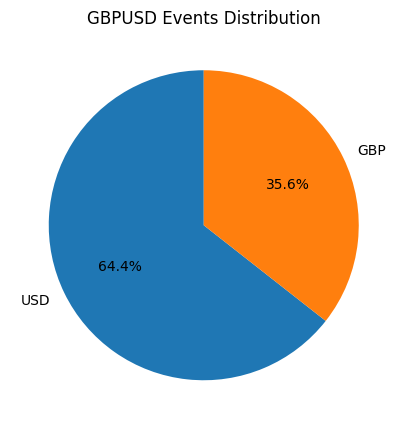

currency
USD    12375
GBP     6837
Name: count, dtype: int64

In [159]:
currency_row_count = frame['currency'].value_counts()
fig,ax = plt.subplots(figsize=(5,8))
ax.pie(currency_row_count, autopct='%1.1f%%', startangle=90,labels=currency_row_count.index)
ax.set_title(DATA + ' Events Distribution')
plt.show()
currency_row_count


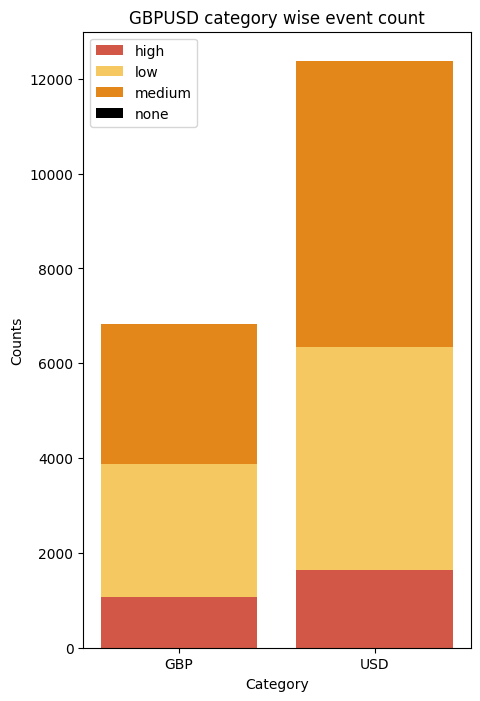

currency  impact
GBP       high      1076
          low       2803
          medium    2958
USD       high      1632
          low       4718
          medium    6024
          none         1
Name: count, dtype: int64

In [160]:
currency_impact = frame[['currency','impact']].value_counts().sort_index()
currency_impact_count = frame.groupby(['currency','impact']).size().unstack(fill_value=0)
fig,ax = plt.subplots(figsize=(5,8))
bottom = None
for impact in currency_impact_count.columns:
    if bottom is None:
        p = ax.bar(currency_impact_count.index, currency_impact_count[impact], label=impact,color=IMPACT_COLORS.get(impact))
        bottom = currency_impact_count[impact]
    else:
        p = ax.bar(currency_impact_count.index, currency_impact_count[impact], bottom=bottom, label=impact,color=IMPACT_COLORS.get(impact))
        bottom += currency_impact_count[impact]
ax.set_xlabel('Category')
ax.set_ylabel('Counts')
ax.legend()
ax.set_title( DATA + ' category wise event count')
plt.show()

# currency_impact_count
currency_impact

In [161]:
frame[frame['impact']=='none'].tail()

,currency,description,impact,result,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,day_of_month,release_period,quarterly_period
time,,,,,,,,,,,,,,
2015-05-21 12:30:00+00:00,USD,Continuing Jobless Claims,none,green,1.56812,1.56567,1.56646,1.56732,12,5,3,21,Normal,Normal


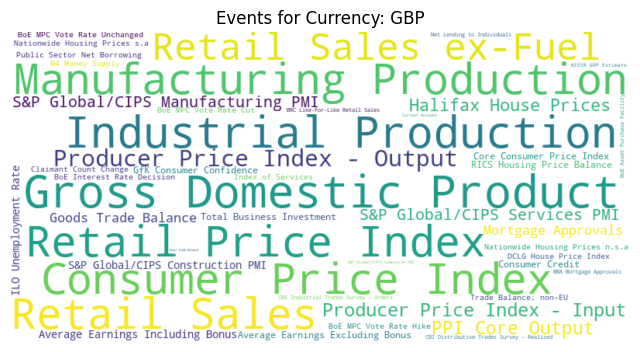

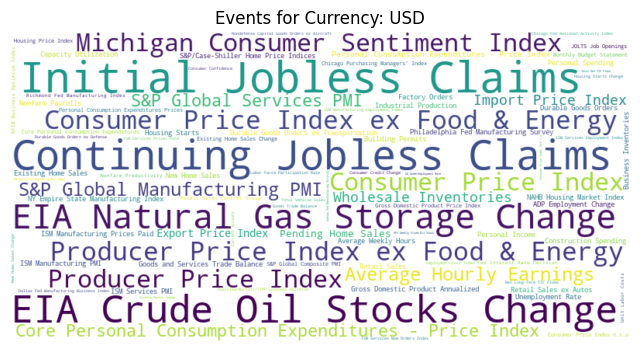

In [162]:

for currency in frame['currency'].unique():
    # Filter descriptions for the current currency
    descriptions = frame[frame['currency'] == currency]['description'].apply(process_description).value_counts()
    d = dict(zip(descriptions.index,descriptions.values))
    # # Generate word frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(d)
    # Plot the WordCloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Events for Currency: {currency}')
    plt.show()

In [163]:
pd.concat([frame['currency'],frame['description'].apply(process_description)], axis=1)[['currency','description']].value_counts().sort_values(ascending=False)

currency  description                          
USD       Initial Jobless Claims                   593
          Continuing Jobless Claims                573
          EIA Crude Oil Stocks Change              557
          EIA Natural Gas Storage Change           535
GBP       Gross Domestic Product                   298
                                                  ... 
          Employment Change                          3
USD       Fed Pace of Treasury Purchase Program      2
          Fed Pace of MBS Purchase Program           2
          4-Week Bill Auction                        1
          20-Year Bond Auction                       1
Name: count, Length: 145, dtype: int64

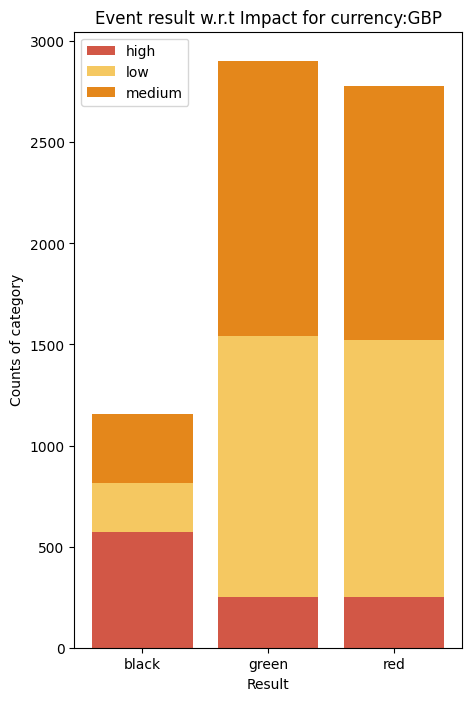

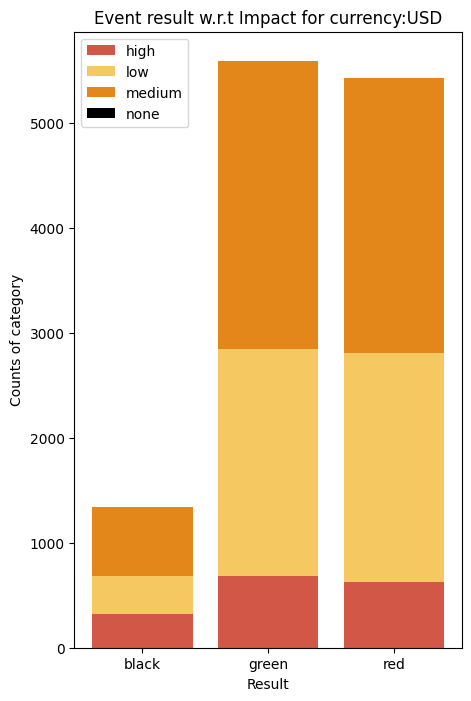

currency  impact  result
GBP       high    black      574
                  green      251
                  red        251
          low     black      242
                  green     1289
                  red       1272
          medium  black      342
                  green     1362
                  red       1254
USD       high    black      324
                  green      685
                  red        623
          low     black      363
                  green     2165
                  red       2190
          medium  black      659
                  green     2742
                  red       2623
          none    green        1
Name: count, dtype: int64

In [164]:
for currency in frame['currency'].unique():
    subframe = frame[frame['currency'] == currency]
    # currency_impact = subframe[['impact','result']].value_counts()
    currency_impact_count = subframe.groupby(['result','impact']).size().unstack(fill_value=0)
    fig,ax = plt.subplots(figsize=(5,8))
    bottom = None
    for impact in currency_impact_count.columns:
        if bottom is None:
            p = ax.bar(currency_impact_count.index, currency_impact_count[impact], label=impact,color=IMPACT_COLORS.get(impact))
            bottom = currency_impact_count[impact]
        else:
            p = ax.bar(currency_impact_count.index, currency_impact_count[impact], bottom=bottom, label=impact,color=IMPACT_COLORS.get(impact))
            bottom += currency_impact_count[impact]
    ax.set_xlabel('Result')
    ax.set_ylabel('Counts of category')
    ax.legend()
    ax.set_title('Event result w.r.t Impact for currency:' + currency)
    plt.show()

    currency_impact_count
    currency_impact
frame[['currency','impact','result']].value_counts().sort_index()

In [165]:
frame.columns

Index(['currency', 'description', 'impact', 'result', '0h', '1h', '3h', '5h',
       'hour_of_day', 'month_of_year', 'day_of_week', 'day_of_month',
       'release_period', 'quarterly_period'],
      dtype='object')

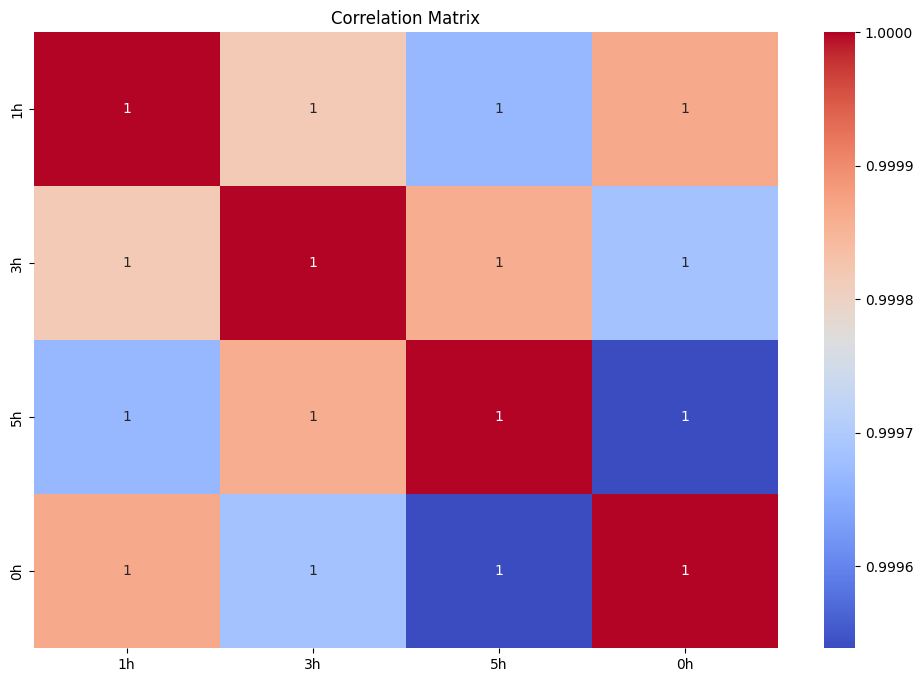

In [166]:
#Visualize the correlation matrix
prices_columns = PREDICTED_FUTURE_PRICES.copy()
prices_columns.append('0h')
plt.figure(figsize=(12, 8))
correlation_matrix = frame[prices_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()



#### Encoder

In [167]:
frame.tail()

,currency,description,impact,result,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,day_of_month,release_period,quarterly_period
time,,,,,,,,,,,,,,
2024-06-28 12:30:00+00:00,USD,Personal Income,medium,green,1.26337,1.26422,1.26416,1.26406,12,6,4,28,MoM,Normal
2024-06-28 12:30:00+00:00,USD,Personal Spending,medium,red,1.26337,1.26422,1.26416,1.26406,12,6,4,28,Normal,Normal
2024-06-28 13:45:00+00:00,USD,Chicago Purchasing Managers' Index,medium,green,1.26422,1.26363,1.26395,1.26406,13,6,4,28,Normal,Normal
2024-06-28 14:00:00+00:00,USD,Michigan Consumer Sentiment Index,medium,green,1.26363,1.26416,1.26406,1.26435,14,6,4,28,Normal,Normal
2024-06-28 14:00:00+00:00,USD,UoM 5-year Consumer Inflation Expectation,medium,red,1.26363,1.26416,1.26406,1.26435,14,6,4,28,Normal,Normal


In [168]:
len(frame.description.unique())

140

In [169]:
EVENT_COLUMNS

['time', 'currency', 'description', 'impact', 'result']

In [170]:
# from sklearn.feature_extraction import FeatureHasher

# # Initialize FeatureHasher
# hasher = FeatureHasher(n_features=1000, input_type='string')

# # Transform the 'description' column
# # Prepare data for FeatureHasher
# hashed_descriptions = [
#     [description] for description in frame['description']
# ]
# description_hashed = hasher.transform(hashed_descriptions)

# # Convert to DataFrame (if needed)
# description_df = pd.DataFrame(description_hashed.toarray())

# # Concatenate with original DataFrame
# frame = pd.concat([frame.drop(columns=['description']), description_df], axis=1)


In [171]:
frame.reset_index(inplace=True)

In [172]:
frame

,time,currency,description,impact,result,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,day_of_month,release_period,quarterly_period
0,2013-01-02 10:28:00+00:00,GBP,S&P Global/CIPS Manufacturing PMI,medium,green,1.62955,1.62951,1.62933,1.62834,10,1,2,2,Normal,Normal
1,2013-01-02 14:58:00+00:00,USD,S&P Global Manufacturing PMI,low,green,1.63044,1.62834,1.62305,1.62446,14,1,2,2,Normal,Normal
2,2013-01-02 16:00:00+00:00,USD,Construction Spending,medium,red,1.62533,1.62305,1.62446,1.62531,16,1,2,2,MoM,Normal
3,2013-01-02 16:00:00+00:00,USD,ISM Manufacturing PMI,high,red,1.62533,1.62305,1.62446,1.62531,16,1,2,2,Normal,Normal
4,2013-01-02 16:00:00+00:00,USD,ISM Manufacturing Prices Paid,medium,green,1.62533,1.62305,1.62446,1.62531,16,1,2,2,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19207,2024-06-28 12:30:00+00:00,USD,Personal Income,medium,green,1.26337,1.26422,1.26416,1.26406,12,6,4,28,MoM,Normal
19208,2024-06-28 12:30:00+00:00,USD,Personal Spending,medium,red,1.26337,1.26422,1.26416,1.26406,12,6,4,28,Normal,Normal
19209,2024-06-28 13:45:00+00:00,USD,Chicago Purchasing Managers' Index,medium,green,1.26422,1.26363,1.26395,1.26406,13,6,4,28,Normal,Normal
19210,2024-06-28 14:00:00+00:00,USD,Michigan Consumer Sentiment Index,medium,green,1.26363,1.26416,1.26406,1.26435,14,6,4,28,Normal,Normal


In [173]:
labelencoder = LabelEncoder()
frame['description'] = labelencoder.fit_transform(frame['description'])

# Apply OneHotEncoder to categorical columns
categorical_columns = ['currency', 'impact', 'result','release_period','quarterly_period']
# categorical_columns = ['currency', 'impact', 'result','release_period','quarterly_period','description']
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_data = encoder.fit_transform(frame[categorical_columns])

# Create DataFrame for the encoded columns
encoded_columns = encoder.get_feature_names_out(categorical_columns)
encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=encoded_columns)

# Drop the original categorical columns and concatenate the encoded columns
frame = frame.drop(columns=categorical_columns).reset_index(drop=True)
frame = pd.concat([frame, encoded_categorical_df], axis=1)

print(frame.head())

                       time  description       0h       1h       3h       5h  \
0 2013-01-02 10:28:00+00:00          127  1.62955  1.62951  1.62933  1.62834   
1 2013-01-02 14:58:00+00:00          123  1.63044  1.62834  1.62305  1.62446   
2 2013-01-02 16:00:00+00:00           26  1.62533  1.62305  1.62446  1.62531   
3 2013-01-02 16:00:00+00:00           68  1.62533  1.62305  1.62446  1.62531   
4 2013-01-02 16:00:00+00:00           69  1.62533  1.62305  1.62446  1.62531   

   hour_of_day  month_of_year  day_of_week  day_of_month  ...  result_red  \
0           10              1            2             2  ...         0.0   
1           14              1            2             2  ...         0.0   
2           16              1            2             2  ...         1.0   
3           16              1            2             2  ...         1.0   
4           16              1            2             2  ...         0.0   

   release_period_MoM  release_period_Normal  release_pe

In [174]:
frame.head()
frame.set_index(pd.to_datetime(frame['time']),inplace=True)
frame.drop(columns=['time'],inplace=True)

In [175]:
frame

,description,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,day_of_month,currency_GBP,...,result_red,release_period_MoM,release_period_Normal,release_period_QoQ,release_period_YoY,quarterly_period_Normal,quarterly_period_Q1,quarterly_period_Q2,quarterly_period_Q3,quarterly_period_Q4
time,,,,,,,,,,,,,,,,,,,,,
2013-01-02 10:28:00+00:00,127,1.62955,1.62951,1.62933,1.62834,10,1,2,2,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 14:58:00+00:00,123,1.63044,1.62834,1.62305,1.62446,14,1,2,2,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,26,1.62533,1.62305,1.62446,1.62531,16,1,2,2,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,68,1.62533,1.62305,1.62446,1.62531,16,1,2,2,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,69,1.62533,1.62305,1.62446,1.62531,16,1,2,2,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28 12:30:00+00:00,106,1.26337,1.26422,1.26416,1.26406,12,6,4,28,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-06-28 12:30:00+00:00,107,1.26337,1.26422,1.26416,1.26406,12,6,4,28,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-06-28 13:45:00+00:00,23,1.26422,1.26363,1.26395,1.26406,13,6,4,28,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [176]:
frame

,description,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,day_of_month,currency_GBP,...,result_red,release_period_MoM,release_period_Normal,release_period_QoQ,release_period_YoY,quarterly_period_Normal,quarterly_period_Q1,quarterly_period_Q2,quarterly_period_Q3,quarterly_period_Q4
time,,,,,,,,,,,,,,,,,,,,,
2013-01-02 10:28:00+00:00,127,1.62955,1.62951,1.62933,1.62834,10,1,2,2,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 14:58:00+00:00,123,1.63044,1.62834,1.62305,1.62446,14,1,2,2,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,26,1.62533,1.62305,1.62446,1.62531,16,1,2,2,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,68,1.62533,1.62305,1.62446,1.62531,16,1,2,2,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,69,1.62533,1.62305,1.62446,1.62531,16,1,2,2,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28 12:30:00+00:00,106,1.26337,1.26422,1.26416,1.26406,12,6,4,28,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-06-28 12:30:00+00:00,107,1.26337,1.26422,1.26416,1.26406,12,6,4,28,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-06-28 13:45:00+00:00,23,1.26422,1.26363,1.26395,1.26406,13,6,4,28,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Encoding the columns

In [177]:
columns = frame.columns.values.tolist()
for item in PREDICTED_FUTURE_PRICES:
    columns.remove(item)
columns

['description',
 '0h',
 'hour_of_day',
 'month_of_year',
 'day_of_week',
 'day_of_month',
 'currency_GBP',
 'currency_USD',
 'impact_high',
 'impact_low',
 'impact_medium',
 'impact_none',
 'result_black',
 'result_green',
 'result_red',
 'release_period_MoM',
 'release_period_Normal',
 'release_period_QoQ',
 'release_period_YoY',
 'quarterly_period_Normal',
 'quarterly_period_Q1',
 'quarterly_period_Q2',
 'quarterly_period_Q3',
 'quarterly_period_Q4']

In [178]:
frame[columns]

,description,0h,hour_of_day,month_of_year,day_of_week,day_of_month,currency_GBP,currency_USD,impact_high,impact_low,...,result_red,release_period_MoM,release_period_Normal,release_period_QoQ,release_period_YoY,quarterly_period_Normal,quarterly_period_Q1,quarterly_period_Q2,quarterly_period_Q3,quarterly_period_Q4
time,,,,,,,,,,,,,,,,,,,,,
2013-01-02 10:28:00+00:00,127,1.62955,10,1,2,2,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 14:58:00+00:00,123,1.63044,14,1,2,2,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,26,1.62533,16,1,2,2,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,68,1.62533,16,1,2,2,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,69,1.62533,16,1,2,2,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28 12:30:00+00:00,106,1.26337,12,6,4,28,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-06-28 12:30:00+00:00,107,1.26337,12,6,4,28,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-06-28 13:45:00+00:00,23,1.26422,13,6,4,28,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [179]:
frame.head()

,description,0h,1h,3h,5h,hour_of_day,month_of_year,day_of_week,day_of_month,currency_GBP,...,result_red,release_period_MoM,release_period_Normal,release_period_QoQ,release_period_YoY,quarterly_period_Normal,quarterly_period_Q1,quarterly_period_Q2,quarterly_period_Q3,quarterly_period_Q4
time,,,,,,,,,,,,,,,,,,,,,
2013-01-02 10:28:00+00:00,127,1.62955,1.62951,1.62933,1.62834,10,1,2,2,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 14:58:00+00:00,123,1.63044,1.62834,1.62305,1.62446,14,1,2,2,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,26,1.62533,1.62305,1.62446,1.62531,16,1,2,2,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,68,1.62533,1.62305,1.62446,1.62531,16,1,2,2,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-02 16:00:00+00:00,69,1.62533,1.62305,1.62446,1.62531,16,1,2,2,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [180]:
from sklearn.model_selection import TimeSeriesSplit

frame.sort_index(inplace=True)
features = frame[columns] # Add more features as needed
target_1h = frame['1h']
target_3h = frame['3h']
target_5h = frame['5h']
# # Split data into training and testing sets
# X_train, X_test, y_train_1h, y_test_1h = train_test_split(features, target_1h, test_size=0.2, random_state=42)
# _, _, y_train_3h, y_test_3h = train_test_split(features, target_3h, test_size=0.2, random_state=42)
# _, _, y_train_5h, y_test_5h = train_test_split(features, target_5h, test_size=0.2, random_state=42)



# train, test = frame[:train_size], frame[train_size:]


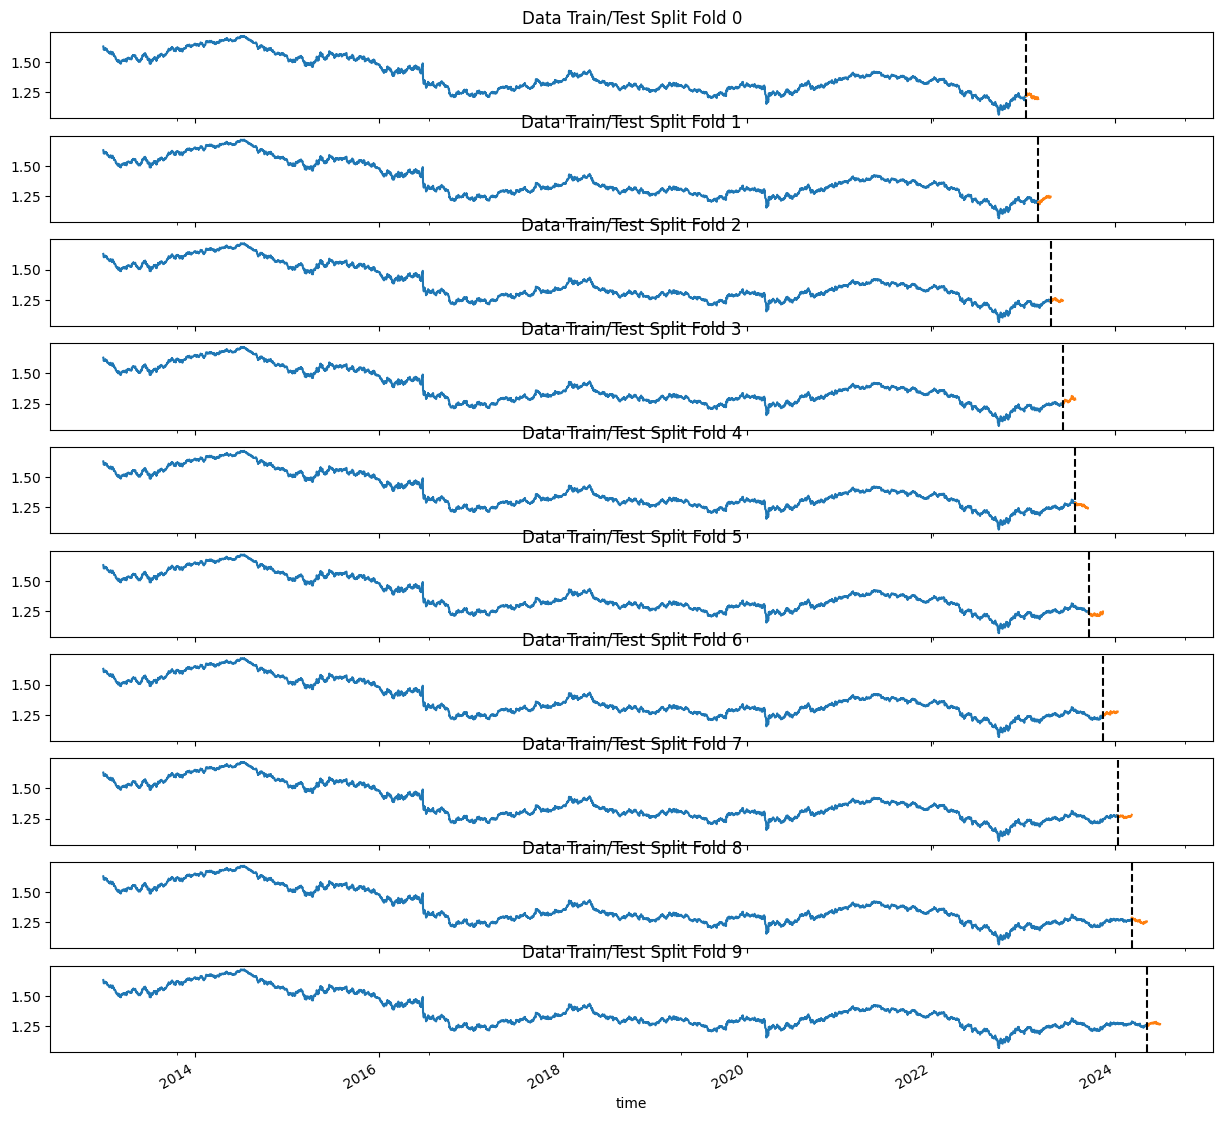

In [181]:
folds= 10
tss = TimeSeriesSplit(n_splits=folds,test_size=250)



fig, axs = plt.subplots(folds, 1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx , val_idx in tss.split(frame):
    train = frame.iloc[train_idx]
    test = frame.iloc[val_idx]
    train['1h'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['1h'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [182]:
from sklearn.linear_model import LinearRegression

# train_size = int(len(frame.index.normalize().unique()) * 0.99)

# # Define the start and end dates for the training period
# window_size_days = train_size  # Number of days in each training set
# step_size_days = 1    # Number of days to move the window

# # Get unique days
# unique_days = frame.index.normalize().unique()
# print(len(unique_days))
# for i in range(window_size_days, len(unique_days)):
#     # Training period
#     train_start_day = unique_days[0]
#     train_end_day = unique_days[i] - pd.Timedelta(seconds=1)
#     # print(train_start_day)
#     # print(train_end_day)
#     # Test period
#     test_start_day = unique_days[i]
#     test_end_day = unique_days[i] + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)

#     print(train_start_day)
#     print(train_end_day)
#     print(test_start_day)
#     print(test_end_day)
#     print()
#     # Slice the DataFrame using date ranges
#     X_train = features[train_start_day:train_end_day]
#     X_test = features[test_start_day:test_end_day]
#     y_train_1h, y_test_1h = target_1h[train_start_day:train_end_day], target_1h[test_start_day:test_end_day]
#     y_train_3h, y_test_3h = target_3h[train_start_day:train_end_day], target_3h[test_start_day:test_end_day]
#     y_train_5h, y_test_5h = target_5h[train_start_day:train_end_day], target_5h[test_start_day:test_end_day]


#     model_1h = LinearRegression()
#     model_3h = LinearRegression()
#     model_5h = LinearRegression()

#     model_1h.fit(X_train, y_train_1h)
#     model_3h.fit(X_train, y_train_3h)
#     model_5h.fit(X_train, y_train_5h)

#     # Predict and evaluate
#     y_pred_1h = model_1h.predict(X_test)
#     y_pred_3h = model_3h.predict(X_test)
#     y_pred_5h = model_5h.predict(X_test)

#     # print("Intercept:",model_1h.intercept_ ,"\nCoefficients:",model_1h.coef_)
#     # print("Intercept:",model_3h.intercept_ ,"\nCoefficients:",model_3h.coef_)
#     # print("Intercept:",model_5h.intercept_ ,"\nCoefficients:",model_5h.coef_)
#     print_metrics(y_test_1h,y_pred_1h,'1h')
#     print_metrics(y_test_3h,y_pred_3h,'3h')
#     print_metrics(y_test_5h,y_pred_5h,'5h')

In [183]:
# from sklearn.ensemble import RandomForestRegressor
# # Rolling forecast origin parameters
# initial_training_days = train_size  # Initial number of days in the training set
# test_window_days = 1       # Number of days in the test set

# # Get unique days
# unique_days = frame.index.normalize().unique()

# # Initialize lists to store the train and test indices
# train_indices = []
# test_indices = []

# # Create rolling forecast origin windows
# for i in range(initial_training_days, len(unique_days)):
#     # Training period
#     train_start_day = unique_days[0]
#     train_end_day = unique_days[i] - pd.Timedelta(seconds=1)
    
#     # Test period
#     test_start_day = unique_days[i]
#     test_end_day = unique_days[i] + pd.Timedelta(days=test_window_days) - pd.Timedelta(seconds=1)
    
#     # Slice the DataFrame using date ranges
#     train = frame[train_start_day:train_end_day]
#     test = frame[test_start_day:test_end_day ]
    
#     print(train_start_day)
#     print(train_end_day)
#     print(test_start_day)
#     print(test_end_day)
#     print()

#     # Train a Random Forest model for each target
#     model_1h = RandomForestRegressor(random_state=42)
#     model_3h = RandomForestRegressor(random_state=42)
#     model_5h = RandomForestRegressor(random_state=42)

#     model_1h.fit(X_train, y_train_1h)
#     model_3h.fit(X_train, y_train_3h)
#     model_5h.fit(X_train, y_train_5h)

#     # Predict and evaluate
#     y_pred_1h = model_1h.predict(X_test)
#     y_pred_3h = model_3h.predict(X_test)
#     y_pred_5h = model_5h.predict(X_test)

#     print_metrics(y_test_1h,y_pred_1h,'1h')
#     print_metrics(y_test_3h,y_pred_3h,'3h')
#     print_metrics(y_test_5h,y_pred_5h,'5h')
   
    


In [184]:
import itertools as it
TRAIN_TEST_LABEL = ['train','test']


In [185]:
# Calculate accuracy metrics

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2_scores = {}
mse_scores = {}
mae_scores = {}
rmse_scores ={}

def reset_evaluation_matrics():
    global r2_scores, mse_scores, mae_scores, rmse_scores
    r2_scores = {}
    mse_scores = {}
    mae_scores = {}
    rmse_scores ={}
    for item in it.product(PREDICTED_FUTURE_PRICES,TRAIN_TEST_LABEL):
        item = '_'.join(item)
        r2_scores[item] , mse_scores[item] , mae_scores[item] , rmse_scores[item] = [] , [], [], []
    # print_vars()

def print_metrics(y_true, y_pred, label):
    global r2_scores, mse_scores, mae_scores, rmse_scores
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2_scores[label].append(r2)
    mse_scores[label].append(mse)
    mae_scores[label].append(mae)
    rmse_scores[label].append(rmse)
    print(f'{label} - R^2: {r2:.4f}')
    print(f'{label} - Mean Absolute Error (MAE): {mae:.4f}')
    print(f'{label} - Mean Squared Error (MSE): {mse:.4f}')
    print(f'{label} - Root Mean Squared Error (RMSE): {rmse:.4f}')
    print('-------------------------------------------')
    # print_vars()
    print('------------------------------------------')

    return (r2,mae,mse,rmse)


def print_vars():
    global r2_scores, mse_scores, mae_scores, rmse_scores
    print(r2_scores)
    print(mse_scores)
    print(mae_scores)
    print(rmse_scores)

In [186]:
from statistics import mean
def model_training(model_function):
    reset_evaluation_matrics()
    print_vars()
    for train_index, test_index in tss.split(frame):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train_1h, y_test_1h = target_1h.iloc[train_index], target_1h.iloc[test_index]
        y_train_3h, y_test_3h = target_3h.iloc[train_index], target_3h.iloc[test_index]
        y_train_5h, y_test_5h = target_5h.iloc[train_index], target_5h.iloc[test_index]
        model_function(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h)

    for label in it.product(PREDICTED_FUTURE_PRICES,TRAIN_TEST_LABEL):
        label = '_'.join(label)
        print(f'Final Scores for {label} prices')
        print(f'{label} - R^2: {mean(r2_scores[label]):.4f}')
        print(f'{label} - Mean Absolute Error (MAE): {mean(mae_scores[label]):.4f}')
        print(f'{label} - Mean Squared Error (MSE): {mean(mse_scores[label]):.4f}')
        print(f'{label} - Root Mean Squared Error (RMSE): {mean(rmse_scores[label]):.4f}')
        print('-----------------------------------------------------------------------------------------------------')
 

In [187]:
def linear_regression_model(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h):
    model_1h = LinearRegression()
    model_3h = LinearRegression()
    model_5h = LinearRegression()

    model_1h.fit(X_train, y_train_1h)
    model_3h.fit(X_train, y_train_3h)
    model_5h.fit(X_train, y_train_5h)

    # Predict and evaluate for train data data
    y_pred_train_1h = model_1h.predict(X_train)
    y_pred_train_3h = model_3h.predict(X_train)
    y_pred_train_5h = model_5h.predict(X_train)

    # Predict and evaluate for test data
    y_pred_test_1h = model_1h.predict(X_test)
    y_pred_test_3h = model_3h.predict(X_test)
    y_pred_test_5h = model_5h.predict(X_test)

    print_metrics(y_train_1h,y_pred_train_1h,'1h_train')
    print_metrics(y_train_3h,y_pred_train_3h,'3h_train')
    print_metrics(y_train_5h,y_pred_train_5h,'5h_train')


    print_metrics(y_test_1h,y_pred_test_1h,'1h_test')
    print_metrics(y_test_3h,y_pred_test_3h,'3h_test')
    print_metrics(y_test_5h,y_pred_test_5h,'5h_test')

In [188]:
model_training(linear_regression_model)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
1h_train - R^2: 0.9997
1h_train - Mean Absolute Error (MAE): 0.0016
1h_train - Mean Squared Error (MSE): 0.0000
1h_train - Root Mean Squared Error (RMSE): 0.0023
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9994
3h_train - Mean Absolute Error (MAE): 0.0025
3h_train - Mean Squared Error (MSE): 0.0000
3h_train - Root Mean Squared Error (RMSE): 0.0036
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9991
5h_train - Mean Absolute Error (MAE): 0.0031
5h_train - Mean Squared Error (MSE): 0.0000
5h_train - Roo

In [189]:
from sklearn.tree import DecisionTreeRegressor

def decision_tree_reg_model(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h):
    # Train a Decision Tree model for each target
    model_1h = DecisionTreeRegressor(random_state=42)
    model_3h = DecisionTreeRegressor(random_state=42)
    model_5h = DecisionTreeRegressor(random_state=42)

    model_1h.fit(X_train, y_train_1h)
    model_3h.fit(X_train, y_train_3h)
    model_5h.fit(X_train, y_train_5h)

    # Predict and evaluate for train data data
    y_pred_train_1h = model_1h.predict(X_train)
    y_pred_train_3h = model_3h.predict(X_train)
    y_pred_train_5h = model_5h.predict(X_train)

    # Predict and evaluate for test data
    y_pred_test_1h = model_1h.predict(X_test)
    y_pred_test_3h = model_3h.predict(X_test)
    y_pred_test_5h = model_5h.predict(X_test)

    print_metrics(y_train_1h,y_pred_train_1h,'1h_train')
    print_metrics(y_train_3h,y_pred_train_3h,'3h_train')
    print_metrics(y_train_5h,y_pred_train_5h,'5h_train')


    print_metrics(y_test_1h,y_pred_test_1h,'1h_test')
    print_metrics(y_test_3h,y_pred_test_3h,'3h_test')
    print_metrics(y_test_5h,y_pred_test_5h,'5h_test')


In [190]:
model_training(decision_tree_reg_model)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
1h_train - R^2: 1.0000
1h_train - Mean Absolute Error (MAE): 0.0000
1h_train - Mean Squared Error (MSE): 0.0000
1h_train - Root Mean Squared Error (RMSE): 0.0000
-------------------------------------------
------------------------------------------
3h_train - R^2: 1.0000
3h_train - Mean Absolute Error (MAE): 0.0000
3h_train - Mean Squared Error (MSE): 0.0000
3h_train - Root Mean Squared Error (RMSE): 0.0000
-------------------------------------------
------------------------------------------
5h_train - R^2: 1.0000
5h_train - Mean Absolute Error (MAE): 0.0000
5h_train - Mean Squared Error (MSE): 0.0000
5h_train - Roo

In [191]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model for each target
def random_forest_regressor_model(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h):
    model_1h = RandomForestRegressor(random_state=42)
    model_3h = RandomForestRegressor(random_state=42)
    model_5h = RandomForestRegressor(random_state=42)

    model_1h.fit(X_train, y_train_1h)
    model_3h.fit(X_train, y_train_3h)
    model_5h.fit(X_train, y_train_5h)

    # Predict and evaluate for train data data
    y_pred_train_1h = model_1h.predict(X_train)
    y_pred_train_3h = model_3h.predict(X_train)
    y_pred_train_5h = model_5h.predict(X_train)

    # Predict and evaluate for test data
    y_pred_test_1h = model_1h.predict(X_test)
    y_pred_test_3h = model_3h.predict(X_test)
    y_pred_test_5h = model_5h.predict(X_test)

    print_metrics(y_train_1h,y_pred_train_1h,'1h_train')
    print_metrics(y_train_3h,y_pred_train_3h,'3h_train')
    print_metrics(y_train_5h,y_pred_train_5h,'5h_train')


    print_metrics(y_test_1h,y_pred_test_1h,'1h_test')
    print_metrics(y_test_3h,y_pred_test_3h,'3h_test')
    print_metrics(y_test_5h,y_pred_test_5h,'5h_test')


In [192]:
model_training(random_forest_regressor_model)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
1h_train - R^2: 1.0000
1h_train - Mean Absolute Error (MAE): 0.0002
1h_train - Mean Squared Error (MSE): 0.0000
1h_train - Root Mean Squared Error (RMSE): 0.0004
-------------------------------------------
------------------------------------------
3h_train - R^2: 1.0000
3h_train - Mean Absolute Error (MAE): 0.0003
3h_train - Mean Squared Error (MSE): 0.0000
3h_train - Root Mean Squared Error (RMSE): 0.0006
-------------------------------------------
------------------------------------------
5h_train - R^2: 1.0000
5h_train - Mean Absolute Error (MAE): 0.0004
5h_train - Mean Squared Error (MSE): 0.0000
5h_train - Roo

In [193]:
import xgboost as xgb
def xgb_regressor_model(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h):
    # Train an XGBoost model for each target
    model_1h = xgb.XGBRegressor(random_state=42)
    model_3h = xgb.XGBRegressor(random_state=42)
    model_5h = xgb.XGBRegressor(random_state=42)

    model_1h.fit(X_train, y_train_1h)
    model_3h.fit(X_train, y_train_3h)
    model_5h.fit(X_train, y_train_5h)

    # Predict and evaluate for train data data
    y_pred_train_1h = model_1h.predict(X_train)
    y_pred_train_3h = model_3h.predict(X_train)
    y_pred_train_5h = model_5h.predict(X_train)

    # Predict and evaluate for test data
    y_pred_test_1h = model_1h.predict(X_test)
    y_pred_test_3h = model_3h.predict(X_test)
    y_pred_test_5h = model_5h.predict(X_test)

    print_metrics(y_train_1h,y_pred_train_1h,'1h_train')
    print_metrics(y_train_3h,y_pred_train_3h,'3h_train')
    print_metrics(y_train_5h,y_pred_train_5h,'5h_train')


    print_metrics(y_test_1h,y_pred_test_1h,'1h_test')
    print_metrics(y_test_3h,y_pred_test_3h,'3h_test')
    print_metrics(y_test_5h,y_pred_test_5h,'5h_test')


In [194]:
model_training(xgb_regressor_model)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
1h_train - R^2: 0.9999
1h_train - Mean Absolute Error (MAE): 0.0012
1h_train - Mean Squared Error (MSE): 0.0000
1h_train - Root Mean Squared Error (RMSE): 0.0017
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9998
3h_train - Mean Absolute Error (MAE): 0.0015
3h_train - Mean Squared Error (MSE): 0.0000
3h_train - Root Mean Squared Error (RMSE): 0.0020
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9997
5h_train - Mean Absolute Error (MAE): 0.0017
5h_train - Mean Squared Error (MSE): 0.0000
5h_train - Roo

In [195]:
from sklearn.svm import SVR

def support_vector_regressor_model(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h):
    # Train an SVR model for each target
    model_1h = SVR()
    model_3h = SVR()
    model_5h = SVR()

    model_1h.fit(X_train, y_train_1h)
    model_3h.fit(X_train, y_train_3h)
    model_5h.fit(X_train, y_train_5h)

    # Predict and evaluate for train data data
    y_pred_train_1h = model_1h.predict(X_train)
    y_pred_train_3h = model_3h.predict(X_train)
    y_pred_train_5h = model_5h.predict(X_train)

    # Predict and evaluate for test data
    y_pred_test_1h = model_1h.predict(X_test)
    y_pred_test_3h = model_3h.predict(X_test)
    y_pred_test_5h = model_5h.predict(X_test)

    print_metrics(y_train_1h,y_pred_train_1h,'1h_train')
    print_metrics(y_train_3h,y_pred_train_3h,'3h_train')
    print_metrics(y_train_5h,y_pred_train_5h,'5h_train')


    print_metrics(y_test_1h,y_pred_test_1h,'1h_test')
    print_metrics(y_test_3h,y_pred_test_3h,'3h_test')
    print_metrics(y_test_5h,y_pred_test_5h,'5h_test')


In [196]:
# model_training(support_vector_regressor_model)

In [197]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


def create_model(X_train_scaled):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def neural_network_model(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h):
    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define a simple feedforward neural network

    # Train a neural network model for each target
    model_1h = create_model(X_train)
    model_3h = create_model(X_train)
    model_5h = create_model(X_train)

    model_1h.fit(X_train, y_train_1h, epochs=20, batch_size=32, verbose=0)
    model_3h.fit(X_train, y_train_3h, epochs=20, batch_size=32, verbose=0)
    model_5h.fit(X_train, y_train_5h, epochs=20, batch_size=32, verbose=0)

    # Predict and evaluate for train data data
    y_pred_train_1h = model_1h.predict(X_train)
    y_pred_train_3h = model_3h.predict(X_train)
    y_pred_train_5h = model_5h.predict(X_train)

    # Predict and evaluate for test data
    y_pred_test_1h = model_1h.predict(X_test)
    y_pred_test_3h = model_3h.predict(X_test)
    y_pred_test_5h = model_5h.predict(X_test)

    print_metrics(y_train_1h,y_pred_train_1h,'1h_train')
    print_metrics(y_train_3h,y_pred_train_3h,'3h_train')
    print_metrics(y_train_5h,y_pred_train_5h,'5h_train')


    print_metrics(y_test_1h,y_pred_test_1h,'1h_test')
    print_metrics(y_test_3h,y_pred_test_3h,'3h_test')
    print_metrics(y_test_5h,y_pred_test_5h,'5h_test')


In [198]:
model_training(neural_network_model)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}


e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 78us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1h_train - R^2: 0.9877
1h_train - Mean Absolute Error (MAE): 0.0087
1h_train - Mean Squared Error (MSE): 0.0002
1h_train - Root Mean Squared Error (RMSE): 0.0156
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9738
3h_train - Mean Absolute Error (MAE): 0.0083
3h_train - Mean Squared Error (MSE): 0.0005
3h_train - Root Mean Squared Error (RMSE): 0.0227
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.8712
5h_train - Mean Absolute Error (MAE): 0.0117
5h_train - Mean Squared Error (MSE): 0.0025
5h_train - Root Mean Squared Error (RMSE): 0.0503
-------------------------------------------
------------------------------------------
1h_test - 

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step
531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step
531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1h_train - R^2: 0.9935
1h_train - Mean Absolute Error (MAE): 0.0072
1h_train - Mean Squared Error (MSE): 0.0001
1h_train - Root Mean Squared Error (RMSE): 0.0113
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.8070
3h_train - Mean Absolute Error (MAE): 0.0093
3h_train - Mean Squared Error (MSE): 0.0038
3h_train - Root Mean Squared Error (RMSE): 0.0618
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9859
5h_train - Mean Absolute Error (MAE): 0.0085
5h_train - Mean Squared Error (MSE): 0.0003
5h_train - Root Mean Squared Error (RMSE): 0.0167
-------------------------------------------
------------------------------------------
1h_test - 

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
1h_train - R^2: 0.8672
1h_train - Mean Absolute Error (MAE): 0.0080
1h_train - Mean Squared Error (MSE): 0.0026
1h_train - Root Mean Squared Error (RMSE): 0.0513
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9093
3h_train - Mean Absolute Error (MAE): 0.0122
3h_train - Mean Squared Error (MSE): 0.0018
3h_train - Root Mean Squared Error (RMSE): 0.0424
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.5559
5h_train - Mean Absolute Error (MAE): 0.0120
5h_train - Mean Squared Error (MSE): 0.0088
5h_train - Root Mean Squared Error (RMSE): 0.0938
-------------------------------------------
------------------------------------------
1h_test -

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1h_train - R^2: 0.9170
1h_train - Mean Absolute Error (MAE): 0.0062
1h_train - Mean Squared Error (MSE): 0.0016
1h_train - Root Mean Squared Error (RMSE): 0.0405
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9768
3h_train - Mean Absolute Error (MAE): 0.0088
3h_train - Mean Squared Error (MSE): 0.0005
3h_train - Root Mean Squared Error (RMSE): 0.0214
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.8054
5h_train - Mean Absolute Error (MAE): 0.0161
5h_train - Mean Squared Error (MSE): 0.0038
5h_train - Root Mean Squared Error (RMSE): 0.0620
-------------------------------------------
------------------------------------------
1h_test - 

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


554/554 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
554/554 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
554/554 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1h_train - R^2: 0.9077
1h_train - Mean Absolute Error (MAE): 0.0062
1h_train - Mean Squared Error (MSE): 0.0018
1h_train - Root Mean Squared Error (RMSE): 0.0426
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9704
3h_train - Mean Absolute Error (MAE): 0.0074
3h_train - Mean Squared Error (MSE): 0.0006
3h_train - Root Mean Squared Error (RMSE): 0.0241
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9906
5h_train - Mean Absolute Error (MAE): 0.0071
5h_train - Mean Squared Error (MSE): 0.0002
5h_train - Root Mean Squared Error (RMSE): 0.0136
-------------------------------------------
------------------------------------------
1h_test -

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1h_train - R^2: 0.8741
1h_train - Mean Absolute Error (MAE): 0.0083
1h_train - Mean Squared Error (MSE): 0.0025
1h_train - Root Mean Squared Error (RMSE): 0.0496
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9477
3h_train - Mean Absolute Error (MAE): 0.0103
3h_train - Mean Squared Error (MSE): 0.0010
3h_train - Root Mean Squared Error (RMSE): 0.0319
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9197
5h_train - Mean Absolute Error (MAE): 0.0124
5h_train - Mean Squared Error (MSE): 0.0016
5h_train - Root Mean Squared Error (RMSE): 0.0396
-------------------------------------------
------------------------------------------
1h_test - 

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


570/570 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
570/570 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
570/570 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1h_train - R^2: 0.9692
1h_train - Mean Absolute Error (MAE): 0.0078
1h_train - Mean Squared Error (MSE): 0.0006
1h_train - Root Mean Squared Error (RMSE): 0.0246
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9950
3h_train - Mean Absolute Error (MAE): 0.0072
3h_train - Mean Squared Error (MSE): 0.0001
3h_train - Root Mean Squared Error (RMSE): 0.0099
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9799
5h_train - Mean Absolute Error (MAE): 0.0099
5h_train - Mean Squared Error (MSE): 0.0004
5h_train - Root Mean Squared Error (RMSE): 0.0198
-------------------------------------------
------------------------------------------
1h_test - R

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1h_train - R^2: 0.8216
1h_train - Mean Absolute Error (MAE): 0.0081
1h_train - Mean Squared Error (MSE): 0.0035
1h_train - Root Mean Squared Error (RMSE): 0.0589
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9672
3h_train - Mean Absolute Error (MAE): 0.0086
3h_train - Mean Squared Error (MSE): 0.0006
3h_train - Root Mean Squared Error (RMSE): 0.0252
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.8799
5h_train - Mean Absolute Error (MAE): 0.0079
5h_train - Mean Squared Error (MSE): 0.0023
5h_train - Root Mean Squared Error (RMSE): 0.0483
-------------------------------------------
------------------------------------------
1h_test - 

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


585/585 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step
585/585 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
585/585 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
1h_train - R^2: 0.7280
1h_train - Mean Absolute Error (MAE): 0.0079
1h_train - Mean Squared Error (MSE): 0.0053
1h_train - Root Mean Squared Error (RMSE): 0.0725
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9904
3h_train - Mean Absolute Error (MAE): 0.0058
3h_train - Mean Squared Error (MSE): 0.0002
3h_train - Root Mean Squared Error (RMSE): 0.0136
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.7610
5h_train - Mean Absolute Error (MAE): 0.0110
5h_train - Mean Squared Error (MSE): 0.0046
5h_train - Root Mean Squared Error (RMSE): 0.0680
-------------------------------------------
------------------------------------------
1h_test - 

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1h_train - R^2: 0.8666
1h_train - Mean Absolute Error (MAE): 0.0144
1h_train - Mean Squared Error (MSE): 0.0026
1h_train - Root Mean Squared Error (RMSE): 0.0506
-------------------------------------------
------------------------------------------
3h_train - R^2: 0.9701
3h_train - Mean Absolute Error (MAE): 0.0071
3h_train - Mean Squared Error (MSE): 0.0006
3h_train - Root Mean Squared Error (RMSE): 0.0240
-------------------------------------------
------------------------------------------
5h_train - R^2: 0.9935
5h_train - Mean Absolute Error (MAE): 0.0080
5h_train - Mean Squared Error (MSE): 0.0001
5h_train - Root Mean Squared Error (RMSE): 0.0112
-------------------------------------------
------------------------------------------
1h_test - 

In [199]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# Defining the RNN model
def build_rnn_model(X_train_rnn):
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def recurrenct_neural_network_model(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h):
    # Scaling the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshaping data for RNN (samples, timesteps, features)
    X_train = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test= X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Training the model for each target
    model_1h = build_rnn_model(X_train)
    model_3h = build_rnn_model(X_train)
    model_5h = build_rnn_model(X_train)
    
    
    model_1h.fit(X_train, y_train_1h, epochs=20, verbose=1)
    model_3h.fit(X_train, y_train_3h, epochs=20, verbose=1)
    model_5h.fit(X_train, y_train_5h, epochs=20, verbose=1)

     # Predict and evaluate for train data data
    y_pred_train_1h = model_1h.predict(X_train)
    y_pred_train_3h = model_3h.predict(X_train)
    y_pred_train_5h = model_5h.predict(X_train)

    # Predict and evaluate for test data
    y_pred_test_1h = model_1h.predict(X_test)
    y_pred_test_3h = model_3h.predict(X_test)
    y_pred_test_5h = model_5h.predict(X_test)

    print_metrics(y_train_1h,y_pred_train_1h,'1h_train')
    print_metrics(y_train_3h,y_pred_train_3h,'3h_train')
    print_metrics(y_train_5h,y_pred_train_5h,'5h_train')


    print_metrics(y_test_1h,y_pred_test_1h,'1h_test')
    print_metrics(y_test_3h,y_pred_test_3h,'3h_test')
    print_metrics(y_test_5h,y_pred_test_5h,'5h_test')


In [200]:
model_training(recurrenct_neural_network_model)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
Epoch 1/20


e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5096
Epoch 2/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0132
Epoch 3/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - loss: 0.0110
Epoch 4/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.0043
Epoch 5/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.0032
Epoch 6/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 0.0098
Epoch 7/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 0.0044
Epoch 8/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 0.0035
Epoch 9/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 0.0032
Epoch 10/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 0.0057
Epoch 11/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - loss: 0.0026
Epoch 12/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.0134
Epoch 13/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 0.0068
Epoch 14/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.0013  
Epoch 15/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 0

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 2s 837us/step - loss: 0.2412
Epoch 2/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 0.0114
Epoch 3/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.0050
Epoch 4/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 0.0032
Epoch 5/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 0.0024
Epoch 6/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 0.0025
Epoch 7/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step - loss: 0.0018
Epoch 8/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 0.0149
Epoch 9/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.0076
Epoch 10/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.0065
Epoch 11/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step - loss: 0.0029
Epoch 12/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - loss: 7.4852e-04
Epoch 13/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.0031 
Epoch 14/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 9.8014e-04
Epoch 15/20
531/531 ━━━━━━━━━━━

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


538/538 ━━━━━━━━━━━━━━━━━━━━ 2s 963us/step - loss: 0.2754
Epoch 2/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 922us/step - loss: 0.0143
Epoch 3/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 0.0062
Epoch 4/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.0038
Epoch 5/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.0020
Epoch 6/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 0.0081
Epoch 7/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 9.3781e-04
Epoch 8/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 0.0119
Epoch 9/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - loss: 0.0117
Epoch 10/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step - loss: 8.7112e-04
Epoch 11/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 0.0027  
Epoch 12/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - loss: 0.0018  
Epoch 13/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 0.0226
Epoch 14/20
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 5.0690e-04
Epoch 15/20
538/538 ━━━━

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 889us/step - loss: 0.3645
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 0.0121
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 0.0055
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 0.0037
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 0.0026
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 0.0029
Epoch 7/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step - loss: 0.0035
Epoch 8/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 0.0095
Epoch 9/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 848us/step - loss: 0.0026 
Epoch 10/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 0.0070
Epoch 11/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 0.0028
Epoch 12/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 0.0020 
Epoch 13/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 0.0018   
Epoch 14/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.0015   
Epoch 15/20
546/546 ━━━━━━━━━━━━

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


554/554 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.9354
Epoch 2/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - loss: 0.0265
Epoch 3/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 0.0094
Epoch 4/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step - loss: 0.0058
Epoch 5/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 0.0038
Epoch 6/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 0.0067
Epoch 7/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - loss: 0.0068
Epoch 8/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step - loss: 0.0219
Epoch 9/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - loss: 0.0044
Epoch 10/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 0.0055
Epoch 11/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - loss: 0.0016  
Epoch 12/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 0.0049  
Epoch 13/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.0359
Epoch 14/20
554/554 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 0.0047
Epoch 15/20
554/554 ━━━━━━━━━━━━━━━━━━

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 892us/step - loss: 0.5565
Epoch 2/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - loss: 0.0312
Epoch 3/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - loss: 0.0081
Epoch 4/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - loss: 0.0040
Epoch 5/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 0.0024
Epoch 6/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 0.0017
Epoch 7/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - loss: 0.0012
Epoch 8/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - loss: 9.4154e-04
Epoch 9/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step - loss: 7.6008e-04
Epoch 10/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 8.2001e-04
Epoch 11/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 6.4010e-04
Epoch 12/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - loss: 0.0385
Epoch 13/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 0.0034
Epoch 14/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 4.8427e-04
Epoch 15/20
562/562 

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


570/570 ━━━━━━━━━━━━━━━━━━━━ 2s 938us/step - loss: 0.1670
Epoch 2/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - loss: 0.0063
Epoch 3/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - loss: 0.0030
Epoch 4/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - loss: 0.0019
Epoch 5/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step - loss: 0.0012
Epoch 6/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - loss: 0.0034
Epoch 7/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step - loss: 0.0012    
Epoch 8/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step - loss: 0.0071
Epoch 9/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step - loss: 0.0038
Epoch 10/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - loss: 0.0019
Epoch 11/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 0.0062
Epoch 12/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step - loss: 0.0033
Epoch 13/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.0027  
Epoch 14/20
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 879us/step - loss: 0.0044 
Epoch 15/20
570/570 ━━━━━━━━━━━━━

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


577/577 ━━━━━━━━━━━━━━━━━━━━ 2s 840us/step - loss: 0.2280
Epoch 2/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - loss: 0.0097
Epoch 3/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - loss: 0.0089
Epoch 4/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step - loss: 0.0083
Epoch 5/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step - loss: 0.0023
Epoch 6/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 0.0050
Epoch 7/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - loss: 0.0088
Epoch 8/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 9.5775e-04
Epoch 9/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - loss: 0.0019   
Epoch 10/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - loss: 0.0074
Epoch 11/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - loss: 0.0048
Epoch 12/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step - loss: 0.0024
Epoch 13/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - loss: 0.0013  
Epoch 14/20
577/577 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - loss: 0.0112
Epoch 15/20
577/577 ━━━━━━━━━━━

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


585/585 ━━━━━━━━━━━━━━━━━━━━ 2s 915us/step - loss: 0.2404
Epoch 2/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - loss: 0.0112
Epoch 3/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.0035
Epoch 4/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - loss: 0.0022
Epoch 5/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - loss: 0.0014
Epoch 6/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - loss: 0.0011
Epoch 7/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - loss: 0.0036
Epoch 8/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0100
Epoch 9/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 924us/step - loss: 0.0062 
Epoch 10/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - loss: 0.0081
Epoch 11/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0049 
Epoch 12/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0054
Epoch 13/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0012  
Epoch 14/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 916us/step - loss: 0.0012   
Epoch 15/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 

e:\project\2024-mcm-ramteks2\src\analysis\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


593/593 ━━━━━━━━━━━━━━━━━━━━ 2s 883us/step - loss: 0.5136
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - loss: 0.0391
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - loss: 0.0089
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - loss: 0.0043
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - loss: 0.0025
Epoch 6/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step - loss: 0.0018
Epoch 7/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step - loss: 0.0013
Epoch 8/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 1s 873us/step - loss: 0.0011
Epoch 9/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - loss: 8.0576e-04
Epoch 10/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step - loss: 0.0017
Epoch 11/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step - loss: 6.6310e-04
Epoch 12/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - loss: 0.0019
Epoch 13/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 1s 867us/step - loss: 0.0015
Epoch 14/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - loss: 9.3726e-04
Epoch 15/20
593/593 ━━━━━━━━

In [201]:
!pip install keras-tcn



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [202]:
from tensorflow.keras.layers import Input, Conv1D, Dense, Lambda, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Defining the TCN model
def build_tcn_model(input_shape):
    i = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(i)
    x = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(x)
    x = Flatten()(x)
    o = Dense(1)(x)
    model = Model(inputs=[i], outputs=[o])
    model.compile(optimizer='adam', loss='mse')
    return model

def temporal_neural_network(X_train,X_test,y_train_1h,y_train_3h,y_train_5h,y_test_1h,y_test_3h,y_test_5h):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Reshaping data for TCN (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Training the model for each target
    model_1h = build_tcn_model((X_train.shape[1], 1))
    model_3h = build_tcn_model((X_train.shape[1], 1))
    model_5h = build_tcn_model((X_train.shape[1], 1))


    model_1h.fit(X_train, y_train_1h, epochs=20, verbose=1)
    model_3h.fit(X_train, y_train_3h, epochs=20, verbose=1)
    model_5h.fit(X_train, y_train_5h, epochs=20, verbose=1)

    # Predict and evaluate for train data data
    y_pred_train_1h = model_1h.predict(X_train)
    y_pred_train_3h = model_3h.predict(X_train)
    y_pred_train_5h = model_5h.predict(X_train)

    # Predict and evaluate for test data
    y_pred_test_1h = model_1h.predict(X_test)
    y_pred_test_3h = model_3h.predict(X_test)
    y_pred_test_5h = model_5h.predict(X_test)

    print_metrics(y_train_1h,y_pred_train_1h,'1h_train')
    print_metrics(y_train_3h,y_pred_train_3h,'3h_train')
    print_metrics(y_train_5h,y_pred_train_5h,'5h_train')


    print_metrics(y_test_1h,y_pred_test_1h,'1h_test')
    print_metrics(y_test_3h,y_pred_test_3h,'3h_test')
    print_metrics(y_test_5h,y_pred_test_5h,'5h_test')


In [203]:
model_training(temporal_neural_network)

{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
{'1h_train': [], '1h_test': [], '3h_train': [], '3h_test': [], '5h_train': [], '5h_test': []}
Epoch 1/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1267
Epoch 2/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0718
Epoch 3/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0177
Epoch 4/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0036
Epoch 5/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0036
Epoch 6/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013  
Epoch 7/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.5706e-04
Epoch 8/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.3336e-04
Epoch 9/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.2294e-04
Epoch 1